## Setting up Environment

In [1]:
# Importing dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

import nibabel as nib
from scipy import ndimage
import random
import math

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.executing_eagerly())
print()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Default GPU Device: /device:GPU:0
True

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4894500730362707675
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1501405342369300776
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [3]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/Data/FLAIR.zip'

Archive:  /content/drive/MyDrive/Colab_Notebooks/Data/FLAIR.zip
   creating: content/project_folder_FLAIR/
   creating: content/project_folder_FLAIR/cross_val_folds/
   creating: content/project_folder_FLAIR/cross_val_folds/test/
   creating: content/project_folder_FLAIR/cross_val_folds/test/0/
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00567.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00176.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00298.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00636.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00147.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00547.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00097.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00774.nii  
  inflating: content/project_folder_FLAIR/cross_val_folds/test/0/00591.nii  
  inflating

In [6]:
data_folder = os.getcwd() + '/data/project_folder_FLAIR/cross_val_folds/fold_1/'

train_img_len = len(os.listdir(data_folder + "train/" + "0/")) + len(os.listdir(data_folder + "train/" + "1/"))
val_img_len = len(os.listdir(data_folder + "val/" + "0/")) + len(os.listdir(data_folder + "val/" + "1/"))

print()
print("Train image length: ", train_img_len)
print("Validation image length: ", val_img_len)


Train image length:  420
Validation image length:  106


In [12]:
# Training parameters (for current simple model provided by the Jupyter notebook)
batch_size = 2
steps_per_epoch = int(math.ceil(train_img_len/batch_size))
validation_steps = int(math.ceil(val_img_len/batch_size))
w_width = 128
h_height = w_width
d_depth = 32

In [8]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = np.min(volume)
    max = np.max(volume)
    volume = (volume) / (max)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [9]:
# Processing .nii images for train/val/test sets
ratings = [0, 1]
project_folder = os.getcwd() + '/data/project_folder_FLAIR/'
paths_test = []
y_test = []
for rating in ratings:
    p = project_folder + 'cross_val_folds/test/' + str(rating) + "/"
    files = os.listdir(p)
    for f in files:
      y_test.append(float(rating))
      paths_test.append(p+f)
print("Paths test: ", paths_test)
print(len(paths_test), len(y_test))
print()
patient_scans_test = np.array([process_scan(path) for path in paths_test])

paths_train = []
y_train = []
for rating in ratings:
    p = project_folder + 'cross_val_folds/fold_1/train/' + str(rating) + "/"
    files = os.listdir(p)
    for f in files:
        y_train.append(float(rating))
        paths_train.append(p+f)
print("Paths train:", paths_train)
print(len(paths_train), len(y_train))
print()
patient_scans_train = np.array([process_scan(path) for path in paths_train])

paths_val = []
y_val = []
for rating in ratings:
    p = project_folder + 'cross_val_folds/fold_1/val/' + str(rating) + "/"
    files = os.listdir(p)
    for f in files:
        # maybe have try-except here to deal with missing .nii files????
        y_val.append(float(rating))
        paths_val.append(p+f)
print("Paths val:", paths_val)
print(len(paths_val), len(y_val))
print()
patient_scans_val = np.array([process_scan(path) for path in paths_val])

x_train = patient_scans_train
y_train = np.array(y_train)
x_val = patient_scans_val
y_val = np.array(y_val)

print("------------------------------------------------")
print("Paths train:", paths_train)
print("Length x_train: ", len(x_train))
print("y_train: ", y_train)
print("Paths val:", paths_val)
print("Length x_val: ", len(x_val))
print("y_val: ", y_val)
print("------------------------------------------------")

Paths test:  ['/content/data/project_folder_FLAIR/cross_val_folds/test/0/00122.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00211.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00214.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00636.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00149.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00569.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00540.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00571.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00774.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00578.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00102.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00567.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/00591.nii', '/content/data/project_folder_FLAIR/cross_val_folds/test/0/0054

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Paths val: ['/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00417.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00158.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00301.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00809.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00452.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00112.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00572.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00410.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00820.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00348.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00709.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0/00430.nii', '/content/data/project_folder_FLAIR/cross_val_folds/fold_1/val/0

In [11]:
a = read_nifti_file('/content/data/project_folder_FLAIR/cross_val_folds/test/0/00122.nii')
a.shape

(256, 256, 20)

In [35]:
# # @tf.function
# def rotate(volume):
#     """Rotate the volume by a few degrees"""
#
#     def scipy_rotate(volume):
#         # define some rotation angles
#         angles = [-20, -10, -5, 5, 10, 20]
#         # pick angles at random
#         angle = random.choice(angles)
#         # rotate volume
#         volume = ndimage.rotate(volume, angle, reshape=False)
#         volume[volume < 0] = 0
#         volume[volume > 1] = 1
#         return volume
#
#     augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
#     return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Augment them on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (128, 128, 32, 1)


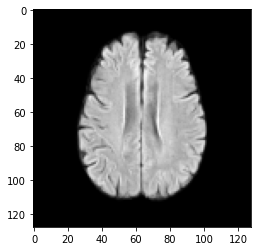

In [14]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 20]), cmap="gray")

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
# plot_slices(4, 5, 128, 128, image[:, :, :40])

In [15]:
def get_model(width=128, height=128, depth=32):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs) # 32 filters
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x) # 32 filters
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x) # 64 filters
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x) #units=64
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# Build model.
model = get_model(width=w_width, height=h_height, depth=d_depth)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 32, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 30, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 15, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 15, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 13, 128)   221312    
                                                             

In [36]:
# Compile model.
epochs = 100
initial_lr = 0.01 #0.0001 # initial learning rate
decay_steps = 100000 # # decay steps in the exponential learning rate scheduler
decay_rate = 0.96 # decay rate for the exponential learning rate scheduler

initial_learning_rate = initial_lr
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
   initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate=initial_lr),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_big.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

In [17]:
# Train the model, doing validation at the end of each epoch
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

print()
print("DONE")

Epoch 1/100
210/210 - 23s - loss: nan - acc: 0.5476 - val_loss: nan - val_acc: 0.4717 - 23s/epoch - 112ms/step
Epoch 2/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 3/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 4/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 5/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 6/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 7/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 8/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 9/100
210/210 - 14s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 14s/epoch - 65ms/step
Epoch 10/

In [48]:
# Helpers functions
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    axis = 4 if backend.image_data_format() == 'channels_last' else 1
    default_bn_params = {
        'axis': axis,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [49]:
# Residual blocks
def residual_bottleneck_block(filters, stage, block, strides=None, cut='pre'):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        cut: one of 'pre', 'post'. used to decide where skip connection is taken
    # Returns
        Output tensor for the block.
    """
  
    def layer(input_tensor):

        # get params and names of layers
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = layers.Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv3D(filters * 4, (1, 1, 1), name=sc_name, strides=strides, **conv_params)(x)
        else:
            raise ValueError('Cut type not in ["pre", "post"]')

        # continue with convolution layers
        x = layers.Conv3D(filters, (1, 1, 1), name=conv_name + '1', **conv_params)(x)

        x = layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = layers.Activation('relu', name=relu_name + '2')(x)
        x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
        x = layers.Conv3D(filters, (3, 3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = layers.BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = layers.Activation('relu', name=relu_name + '3')(x)
        x = layers.Conv3D(filters * 4, (1, 1, 1), name=conv_name + '3', **conv_params)(x)

        # add residual connection
        x = layers.Add()([x, shortcut])

        return x

    return layer

In [50]:
# Residual Model Builder
def ResNet(model_params, input_shape=None, input_tensor=None, include_top=True,
           classes=1000, weights='imagenet', **kwargs):
    """Instantiates the ResNet, SEResNet architecture.

    Args:
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    Returns:
        A Keras model instance.

    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    global backend, layers, models, keras_utils
    backend = keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape, name='data')
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # choose residual block type
    ResidualBlock = model_params[2]

    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    # resnet bottom
    x = layers.BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = layers.ZeroPadding3D(padding=(3, 3, 3))(x)
    x = layers.Conv3D(init_filters, (7, 7, 7), strides=(2, 2, 2), name='conv0', **conv_params)(x)
    x = layers.BatchNormalization(name='bn0', **bn_params)(x)
    x = layers.Activation('relu', name='relu0')(x)
    x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='valid', name='pooling0')(x)

    # resnet body
    for stage, rep in enumerate(model_params[1]):
        for block in range(rep):

            filters = init_filters * (2 ** stage)

            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = ResidualBlock(filters, stage, block, strides=(1, 1, 1), cut='post')(x)

            elif block == 0:
                x = ResidualBlock(filters, stage, block, strides=(2, 2, 2), cut='post')(x)

            else:
                x = ResidualBlock(filters, stage, block, strides=(1, 1, 1), cut='pre')(x)

    x = layers.BatchNormalization(name='bn1', **bn_params)(x)
    x = layers.Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = layers.GlobalAveragePooling3D(name='pool1')(x)
        x = layers.Dense(units=1, activation="sigmoid", name='fc1')(x)
        
    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x)

    return model

In [51]:
MODELS_PARAMS = ['resnet50', (3, 4, 6, 3), residual_bottleneck_block]
w_width = 128
h_height = w_width
d_depth = 32
classes = 2
input_shape = (w_width, h_height, d_depth, 1)

In [55]:
def ResNet50(input_shape=None, input_tensor=None, weights=None, classes=1000, include_top=True, **kwargs):
    return ResNet(
        MODELS_PARAMS,
        input_shape=input_shape,
        input_tensor=input_tensor,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )

# Build model.
model = ResNet50(input_shape, classes=2)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                2, 1)]                                                            
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 32  3           ['data[0][0]']                   
                                , 1)                                                              
                                                                                                  
 zero_padding3d_90 (ZeroPadding  (None, 134, 134, 38  0          ['bn_data[0][0]']                
 3D)                            , 1)                                                        

In [56]:
# Compile model.
epochs = 100
initial_lr = 0.001 #0.0001 # initial learning rate
decay_steps = 100000 # # decay steps in the exponential learning rate scheduler
decay_rate = 0.96 # decay rate for the exponential learning rate scheduler

initial_learning_rate = initial_lr
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
   initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate=initial_lr),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_big.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

In [57]:
# Train the model, doing validation at the end of each epoch
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    # steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

print()
print("DONE")

Epoch 1/100
210/210 - 26s - loss: nan - acc: 0.4905 - val_loss: nan - val_acc: 0.4717 - 26s/epoch - 123ms/step
Epoch 2/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 3/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 4/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 5/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 6/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 7/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 8/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 9/100
210/210 - 21s - loss: nan - acc: 0.4762 - val_loss: nan - val_acc: 0.4717 - 21s/epoch - 99ms/step
Epoch 10/